# Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
tfk = tf.keras
tfkl = tf.keras.layers

In [ ]:
# Download and import visualkeras library
!pip install visualkeras
import visualkeras

# Mount Gdrive

In [ ]:
# Reading files from google drive slow down your training process. The solution is to upload zip file to 
# colab and unzip there. Hope it is clear for you
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/MyDrive/
%ls

/gdrive/MyDrive
'Colab Notebooks'/   Gabriele/         model.png   SimplerModel/    training/
 Dataset/            IncpetionModel/   S3CRET/     StandardModel/


In [ ]:
!unzip Dataset/dataset.zip -d Dataset/

Output streaming troncato alle ultime 5000 righe.
  inflating: Dataset/training/Tomato/37979.jpg  
  inflating: Dataset/training/Tomato/37980.jpg  
  inflating: Dataset/training/Tomato/37982.jpg  
  inflating: Dataset/training/Tomato/37983.jpg  
  inflating: Dataset/training/Tomato/37984.jpg  
  inflating: Dataset/training/Tomato/37985.jpg  
  inflating: Dataset/training/Tomato/37988.jpg  
  inflating: Dataset/training/Tomato/37989.jpg  
  inflating: Dataset/training/Tomato/37990.jpg  
  inflating: Dataset/training/Tomato/37992.jpg  
  inflating: Dataset/training/Tomato/37993.jpg  
  inflating: Dataset/training/Tomato/37994.jpg  
  inflating: Dataset/training/Tomato/37995.jpg  
  inflating: Dataset/training/Tomato/37996.jpg  
  inflating: Dataset/training/Tomato/37997.jpg  
  inflating: Dataset/training/Tomato/37998.jpg  
  inflating: Dataset/training/Tomato/37999.jpg  
  inflating: Dataset/training/Tomato/38000.jpg  
  inflating: Dataset/training/Tomato/38001.jpg  
  inflating: Datase

# Set seed for reproducibility


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load and Explore the dataset

In [ ]:
# Dataset folders 
dataset_dir = 'Dataset'
training_dir = os.path.join(dataset_dir, 'training')


# Inspect image dimension
img = Image.open('{}/training/{}/{}'.format(dataset_dir, 'Apple', '00001.jpg'))
img_height = img.height
img_width = img.width

print('[{},{}]'.format(img_height, img_width))

# plot one sample images per class
labels = ["Apple", "Cherry", "Grape", "Peach", "Potato", "Soybean", 
          "Strawberry", "Blueberry", "Corn", "Orange", 
          "Pepper", "Raspberry", "Squash", "Tomato"]

[256,256]


In [ ]:
# Images are divided into folders, one for each class.  
# Exploit ImageDataGenerator to read them from disk.
batch_size = 256
validation_split = .2

# Create an instance of ImageDataGenerator
train_data_gen = ImageDataGenerator(
    validation_split=validation_split #set the validation split
)

# Obtain a data generatorfor training
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(img_height,img_width),
                                               batch_size=batch_size,
                                               subset = 'training',
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed)
# Obtain a data generator for validation
val_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                             target_size=(img_height,img_width),
                                             batch_size=batch_size,
                                             subset = 'validation',
                                             color_mode='rgb',
                                             classes=None,
                                             class_mode='categorical',
                                             shuffle=False, # no need to shuffle for validation
                                             seed=seed)

Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.


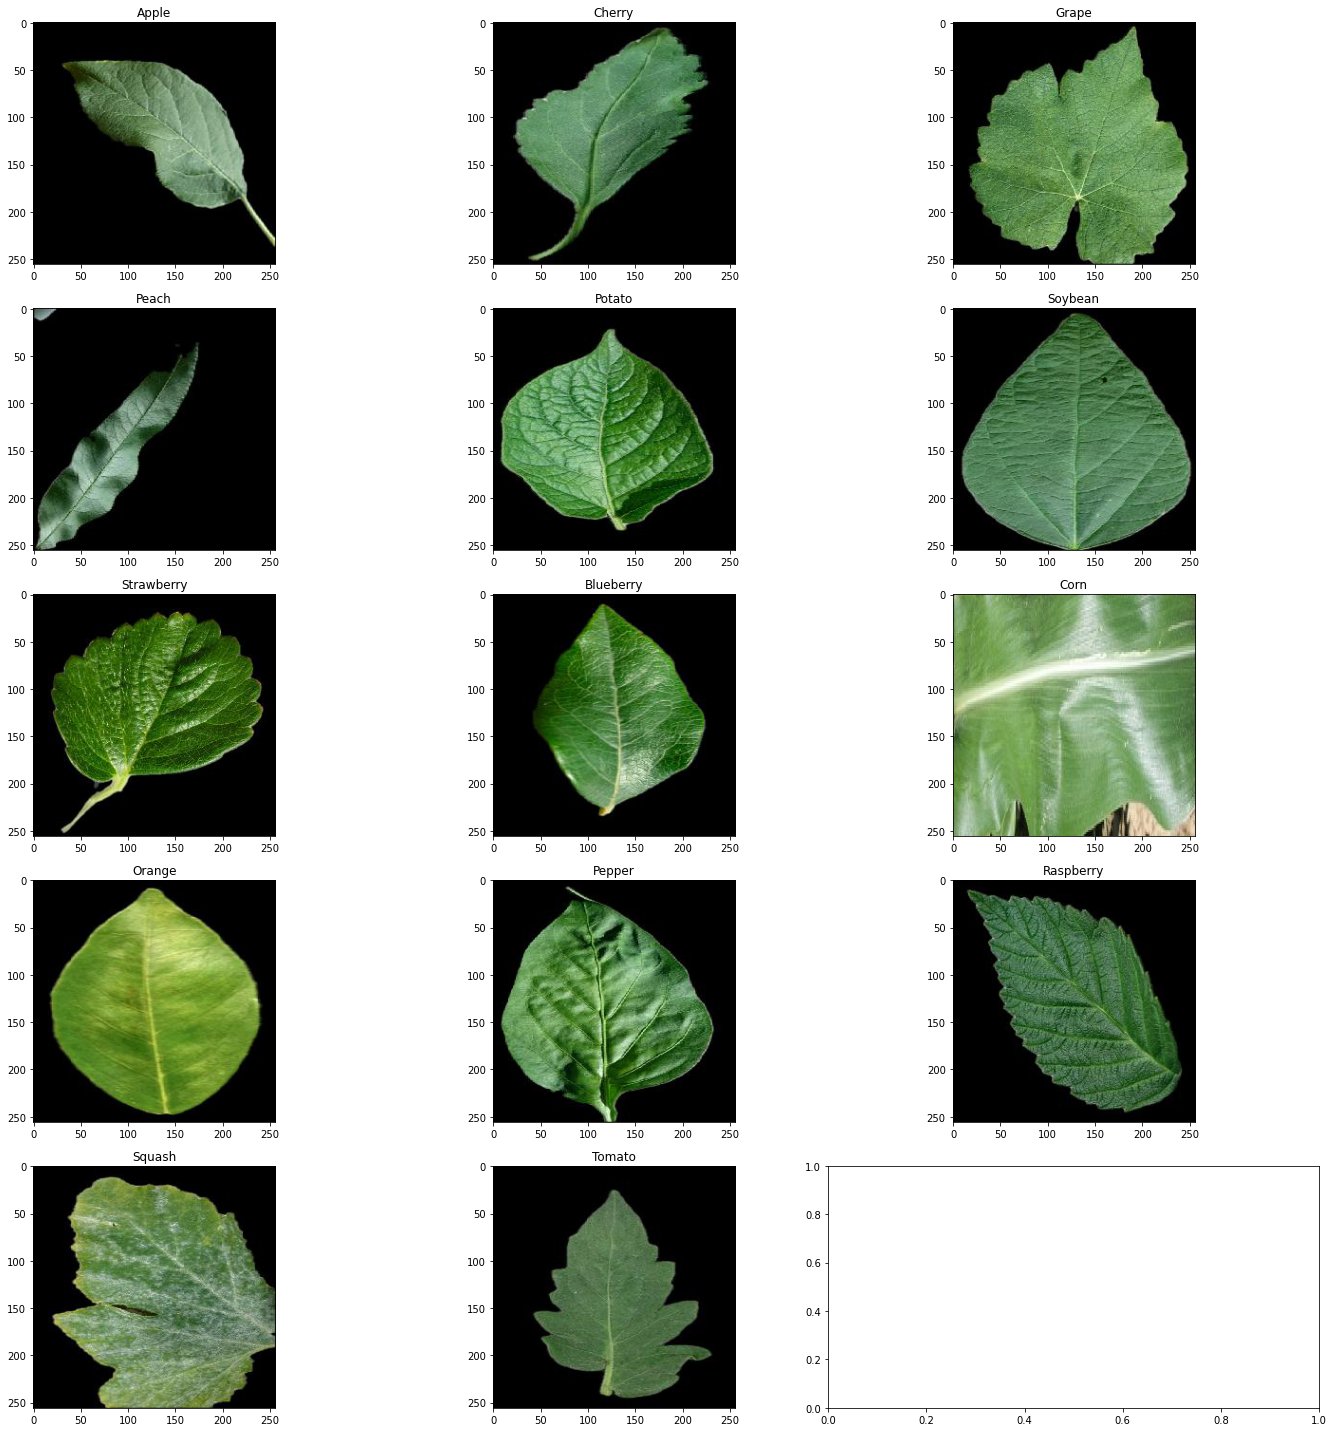

In [ ]:

# Plot an instance of each class
nrow = 5
ncol = 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20,20))

for i in range(nrow*ncol):
  if i < 14:
    class_imgs = next(os.walk('{}/training/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0] #select the first img of each class to show
    img = Image.open('{}/training/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//ncol, i%ncol] #i=5 -> 5//3 =1 5%3 =2 si seleziona la riga 1 e colonna 2
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()


Assigned labels
{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}

Target classes
{0: 791, 1: 374, 2: 467, 3: 965, 4: 1167, 5: 1399, 6: 782, 7: 612, 8: 573, 9: 212, 10: 1293, 11: 460, 12: 539, 13: 4555}



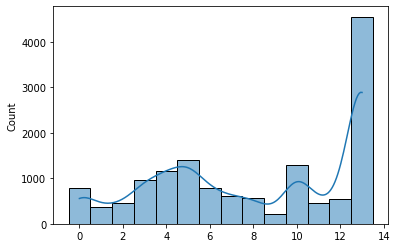

In [ ]:
# Inspect the target distribution
print("Assigned labels")
print(train_gen.class_indices)

print()
print("Target classes")
class_instances = train_gen.classes
target_class, counts = np.unique(class_instances, return_counts=True)
stats = dict(zip(target_class, counts))
print(stats)
print()
sns.histplot(data= class_instances, kde = True, discrete=True)
# thre can be a class imbalance problem


# Prepare the Data (no data augmentation)

In [ ]:
# use generator to prepare the data
batch_size = 256
validation_split = .3
norm_factor =1/255 #for normalization

# Create an instance of ImageDataGenerator
train_data_gen = ImageDataGenerator(
    validation_split=validation_split, #set the validation split
    rescale = norm_factor,
)

# Obtain a data generatorfor training
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(img_height,img_width),
                                               batch_size=batch_size,                                        
                                               subset = 'training',
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed)
# Obtain a data generator for validation
val_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                             target_size=(img_height,img_width),
                                             batch_size=batch_size,
                                             subset = 'validation',
                                             color_mode='rgb',
                                             classes=None,
                                             class_mode='categorical',
                                             shuffle=True, # no need to shuffle for validation
                                             seed=seed)

Found 12417 images belonging to 14 classes.
Found 5311 images belonging to 14 classes.


# Model, Training, Evaluation

In [ ]:
# Model metadata
input_shape = (img_height, img_width, 3)
dropout = 0.3
output_class = len(labels)

In [ ]:
# trying a  simple model

def build_simpler_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #resize_layer = tfkl.Resizing(64, 64, interpolation="bicubic")(input_layer)

    conv1 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'Conv1')(input_layer)
    pool1 = tfkl.MaxPooling2D(name = 'Pool1')(conv1)

    conv2 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'Conv2')(pool1)
    pool2 = tfkl.MaxPooling2D(name = 'Pool2')(conv2)

    conv3 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'Conv3')(pool2)
    glob_pooling = tfkl.GlobalAveragePooling2D(name='GloablPooling')(conv3)
    glob_pooling = tfkl.Dropout(0.3, seed=seed, name='GloablPoolingDropout')(glob_pooling)

    classifier_layer = tfkl.Dense(
        units=256,  
        activation='relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Classifier')(glob_pooling)
    classifier_layer = tfkl.Dropout(0.3, seed=seed, name='ClassifierDropout')(classifier_layer)

    output_layer = tfkl.Dense(
        units=output_class, 
        activation='softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
simpler_model = build_simpler_model(input_shape)
simpler_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 256, 256, 64)      1792      
                                                                 
 Pool1 (MaxPooling2D)        (None, 128, 128, 64)      0         
                                                                 
 Conv2 (Conv2D)              (None, 128, 128, 128)     73856     
                                                                 
 Pool2 (MaxPooling2D)        (None, 64, 64, 128)       0         
                                                                 
 Conv3 (Conv2D)              (None, 64, 64, 256)       295168    
                                                                 
 GloablPooling (GlobalAverag  (None, 256)              0     

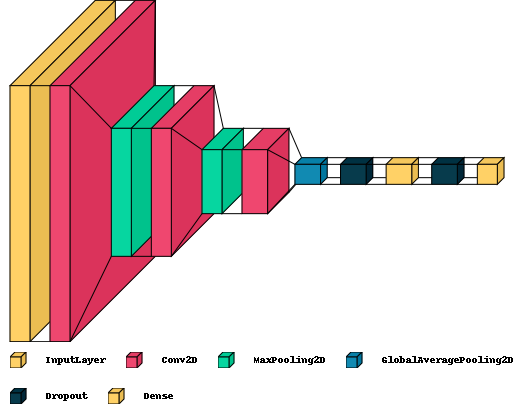

In [ ]:
visualkeras.layered_view(simpler_model, legend=True, spacing=20, scale_xy=1)

In [ ]:
# Train simpler model
epochs = 100

simple_history = simpler_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = val_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)] # Early stopping
).history

Epoch 1/100


In [ ]:
# Save th model
simpler_model.save('SimplerModel') #seved in gdrive(SimplerMOdel)

INFO:tensorflow:Assets written to: SimplerModel/assets


INFO:tensorflow:Assets written to: SimplerModel/assets


In [ ]:
# Load the saved model
simpler_model = tfk.models.load_model('SimplerModel')

training loss 0.07607758790254593
training accuracy 0.9767425656318665

validation loss 0.11436803638935089
validation accuracy 0.9643967151641846


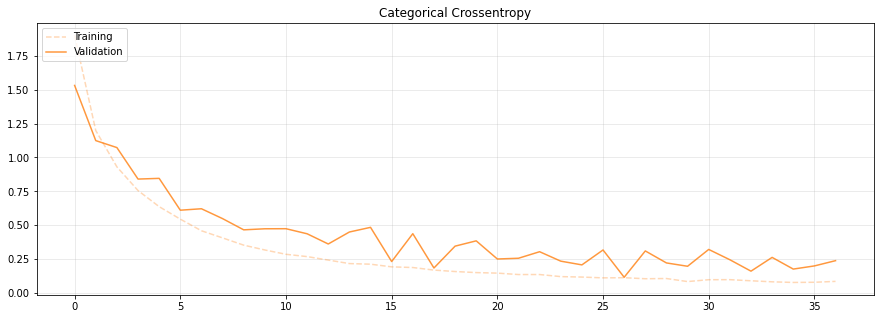

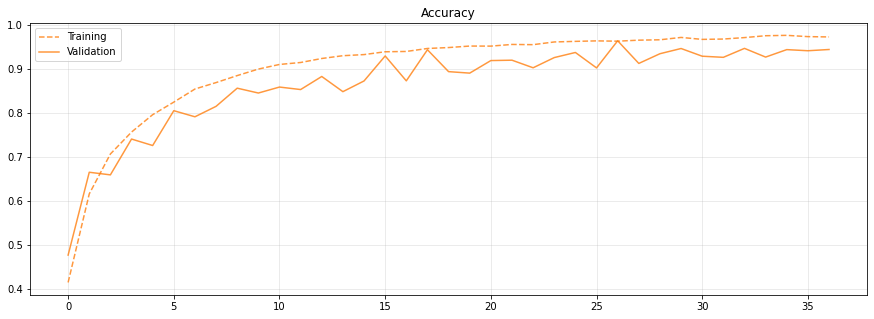

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(simple_history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(simple_history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(simple_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(simple_history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

print('training loss',min(simple_history['loss']))
print('training accuracy',max(simple_history['accuracy']))
print()
print('validation loss',min(simple_history['val_loss']))
print('validation accuracy',max(simple_history['val_accuracy']))


plt.show()

In [ ]:


def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[200]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch



(Input) image shape: (3539, 256, 256, 3)
Target shape: (3539, 14)

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 0
Class name: Apple
Accuracy: 0.3736
Precision: 0.3935
Recall: 0.391
F1: 0.2951


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


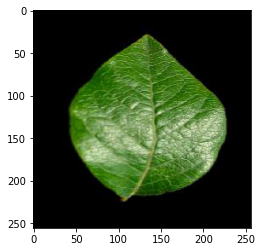

In [ ]:
# Get a sample from dataset and show info
batch = get_next_batch(val_gen)

# Check the performance on the validation set
X_test = batch[0]
y_test = batch[1]

# Predict the test set with the CNN
predictions = simpler_model.predict(X_test)
predictions.shape

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))



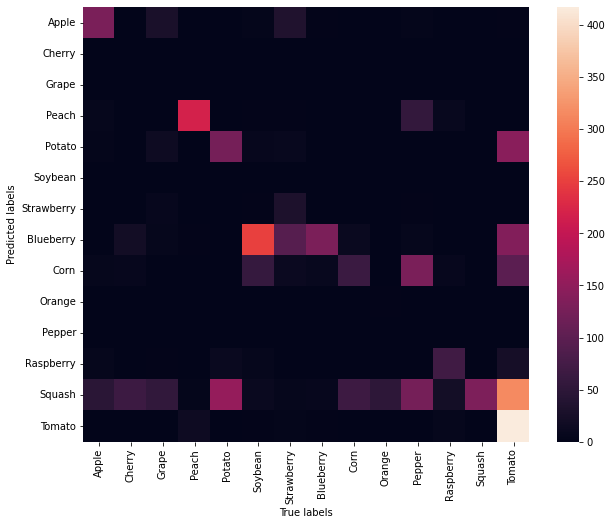

In [ ]:
# Plot the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels), yticklabels=list(labels))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Transfer learning

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                   

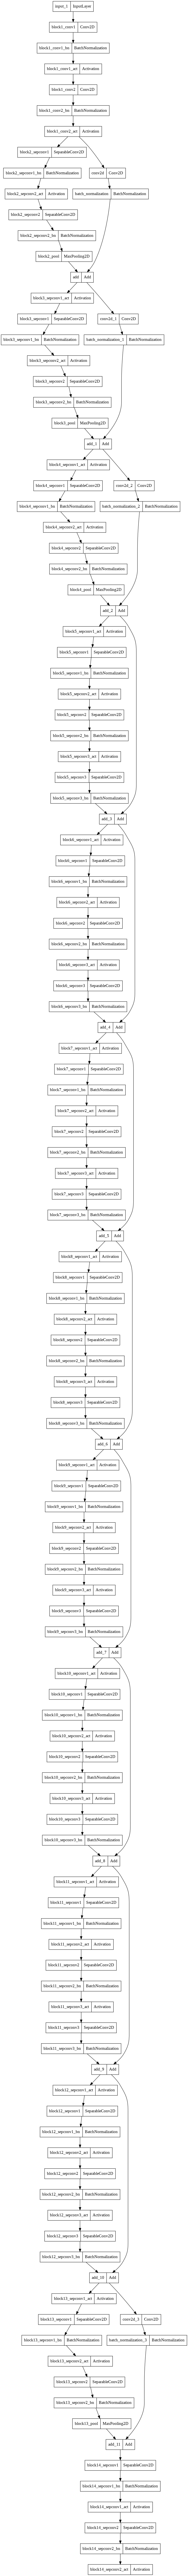

In [ ]:
# Download and plot the Xception model
supernet = tfk.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256 ,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [ ]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(256,256,3))
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
xception_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
xception_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
xception_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 Flattening (Flatten)        (None, 131072)            0         
                                                                 
 dropout_4 (Dropout)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 14)                3598  

In [ ]:
# Train the model
xception_history =xception_model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = val_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)] # Early stopping
).history

Epoch 1/200
56/56 [==============================] - 240s 4s/step - loss: 2.9185 - accuracy: 0.7300 - val_loss: 0.4211 - val_accuracy: 0.8771
Epoch 2/200
56/56 [==============================] - 191s 3s/step - loss: 0.2674 - accuracy: 0.9154 - val_loss: 0.2902 - val_accuracy: 0.9116
Epoch 3/200
56/56 [==============================] - 190s 3s/step - loss: 0.1559 - accuracy: 0.9493 - val_loss: 0.2002 - val_accuracy: 0.9398
Epoch 4/200
56/56 [==============================] - 190s 3s/step - loss: 0.1108 - accuracy: 0.9631 - val_loss: 0.2248 - val_accuracy: 0.9330
Epoch 5/200
56/56 [==============================] - 190s 3s/step - loss: 0.0762 - accuracy: 0.9759 - val_loss: 0.2252 - val_accuracy: 0.9353
Epoch 6/200
56/56 [==============================] - 190s 3s/step - loss: 0.0639 - accuracy: 0.9786 - val_loss: 0.2066 - val_accuracy: 0.9376
Epoch 7/200
56/56 [==============================] - 191s 3s/step - loss: 0.0471 - accuracy: 0.9846 - val_loss: 0.2360 - val_accuracy: 0.9342
Epoch 

In [ ]:
# Save the model
xception_model.save('IncpetionModel1') #seved in gdrive(SimplerMOdel)

INFO:tensorflow:Assets written to: IncpetionModel1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Load the saved model
xception_model = tfk.models.load_model('IncpetionModel1')


In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[200]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (3539, 256, 256, 3)
Target shape: (3539, 14)

Categorical label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Label: 13
Class name: Tomato
Accuracy: 0.9675
Precision: 0.9602
Recall: 0.9649
F1: 0.962


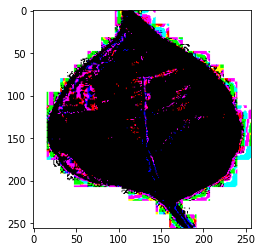

In [ ]:

# Get a sample from dataset and show info
batch = get_next_batch(val_gen)

# Check the performance on the validation set
X_test = batch[0]
y_test = batch[1]
# Predict the test set with the CNN
predictions = xception_model.predict(X_test)
predictions.shape

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))



# Fine Tuning

In [ ]:
# Re-load the model after transfer learning
xception_ft_model = tfk.models.load_model('IncpetionModel1')
xception_ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 Flattening (Flatten)        (None, 131072)            0         
                                                                 
 dropout_4 (Dropout)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 14)                3598  

In [ ]:
# Set all xception layers to True
xception_ft_model.get_layer('xception').trainable = True
for i, layer in enumerate(xception_ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d True
13 block2_pool True
14 batch_normalization True
15 add True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_1 True
23 block3_pool True
24 batch_normalization_1 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_2 True
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 block5_sep

In [ ]:
# Freeze first N layers
N = 100
for i, layer in enumerate(xception_ft_model.get_layer('xception').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(xception_ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)
xception_ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

In [ ]:
# Compile the model
xception_ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
# Fine-tune the model
xception_ft_history =xception_ft_model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = val_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)] # Early stopping
).history

Epoch 1/200
56/56 [==============================] - 304s 5s/step - loss: 0.0714 - accuracy: 0.9779 - val_loss: 0.2120 - val_accuracy: 0.9494
Epoch 2/200
56/56 [==============================] - 283s 5s/step - loss: 0.0130 - accuracy: 0.9955 - val_loss: 0.1771 - val_accuracy: 0.9587
Epoch 3/200
56/56 [==============================] - 284s 5s/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 0.1533 - val_accuracy: 0.9638
Epoch 4/200
56/56 [==============================] - 284s 5s/step - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0.1745 - val_accuracy: 0.9664
Epoch 5/200
56/56 [==============================] - 283s 5s/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.2703 - val_accuracy: 0.9562
Epoch 6/200
56/56 [==============================] - 284s 5s/step - loss: 0.0058 - accuracy: 0.9980 - val_loss: 0.2912 - val_accuracy: 0.9373
Epoch 7/200
56/56 [==============================] - 283s 5s/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.2457 - val_accuracy: 0.9610
Epoch 

In [ ]:
# Save the model
xception_ft_model.save('IncpetionFtModel1') #seved in gdrive(SimplerMOdel)

INFO:tensorflow:Assets written to: IncpetionFtModel1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Load the saved model
xception_ft_model = tfk.models.load_model('IncpetionFtModel1')


(Input) image shape: (3539, 256, 256, 3)
Target shape: (3539, 14)

Categorical label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 2
Class name: Grape
Accuracy: 0.9819
Precision: 0.9776
Recall: 0.9788
F1: 0.9777


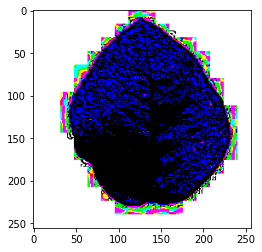

In [ ]:

# Get a sample from dataset and show info
batch = get_next_batch(val_gen)

# Check the performance on the validation set
X_test = batch[0]
y_test = batch[1]
# Predict the test set with the CNN
predictions = xception_ft_model.predict(X_test)
predictions.shape

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))



# Fine Tuning

In [ ]:
# Re-load the model after transfer learning
xception_ft_model = tfk.models.load_model('IncpetionModel1')
xception_ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 Flattening (Flatten)        (None, 131072)            0         
                                                                 
 dropout_4 (Dropout)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 14)                3598  

In [ ]:
# Set all xception layers to True
xception_ft_model.get_layer('xception').trainable = True
for i, layer in enumerate(xception_ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d True
13 block2_pool True
14 batch_normalization True
15 add True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_1 True
23 block3_pool True
24 batch_normalization_1 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_2 True
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 block5_sep

In [ ]:
# Freeze first N layers
N = 100
for i, layer in enumerate(xception_ft_model.get_layer('xception').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(xception_ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)
xception_ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

In [ ]:
# Compile the model
xception_ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
# Fine-tune the model
xception_ft_history =xception_ft_model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = val_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)] # Early stopping
).history

Epoch 1/200
56/56 [==============================] - 304s 5s/step - loss: 0.0714 - accuracy: 0.9779 - val_loss: 0.2120 - val_accuracy: 0.9494
Epoch 2/200
56/56 [==============================] - 283s 5s/step - loss: 0.0130 - accuracy: 0.9955 - val_loss: 0.1771 - val_accuracy: 0.9587
Epoch 3/200
56/56 [==============================] - 284s 5s/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 0.1533 - val_accuracy: 0.9638
Epoch 4/200
56/56 [==============================] - 284s 5s/step - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0.1745 - val_accuracy: 0.9664
Epoch 5/200
56/56 [==============================] - 283s 5s/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.2703 - val_accuracy: 0.9562
Epoch 6/200
56/56 [==============================] - 284s 5s/step - loss: 0.0058 - accuracy: 0.9980 - val_loss: 0.2912 - val_accuracy: 0.9373
Epoch 7/200
56/56 [==============================] - 283s 5s/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.2457 - val_accuracy: 0.9610
Epoch 

In [ ]:
# Save the model
xception_ft_model.save('IncpetionFtModel1') #seved in gdrive(SimplerMOdel)

INFO:tensorflow:Assets written to: IncpetionFtModel1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Load the saved model
xception_ft_model = tfk.models.load_model('IncpetionFtModel1')


(Input) image shape: (3539, 256, 256, 3)
Target shape: (3539, 14)

Categorical label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 2
Class name: Grape
Accuracy: 0.9819
Precision: 0.9776
Recall: 0.9788
F1: 0.9777


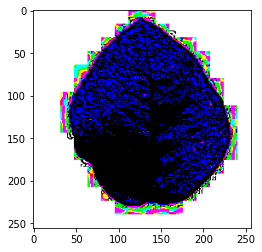

In [ ]:

# Get a sample from dataset and show info
batch = get_next_batch(val_gen)

# Check the performance on the validation set
X_test = batch[0]
y_test = batch[1]
# Predict the test set with the CNN
predictions = xception_ft_model.predict(X_test)
predictions.shape

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))



# Augmented data

In [ ]:
# Apply same preprocessing used to train the supernet 
from tensorflow.keras.applications.xception import preprocess_input 

# use generator to prepare the data
batch_size = 256
validation_split = .2

# Create an instance of ImageDataGenerator with augmentation
aug_train_data_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range=30,
    height_shift_range=50,
    width_shift_range=50,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True, 
    fill_mode='reflect',
    validation_split=validation_split, #set the validation split
    
)

# Obtain a data generatorfor training
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(img_height,img_width),
                                               batch_size=batch_size,                                        
                                               subset = 'training',
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed)
# Obtain a data generator for validation
val_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                             target_size=(img_height,img_width),
                                             batch_size=batch_size,
                                             subset = 'validation',
                                             color_mode='rgb',
                                             classes=None,
                                             class_mode='categorical',
                                             shuffle=True, # no need to shuffle for validation
                                             seed=seed)

Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.


In [ ]:
# load the previous xception fine tuned model
xception_ft_aug_model = tfk.models.load_model('IncpetionFtModel1')
xception_ft_aug_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 Flattening (Flatten)        (None, 131072)            0         
                                                                 
 dropout_4 (Dropout)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 14)                3598  

In [ ]:
# Train the model
xception_aug_history =xception_ft_aug_model.fit(
    x = aug_train_gen,
    epochs = 200,
    validation_data = val_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)] # Early stopping
).history

In [ ]:
# Save the model
xception_ft_aug_model.save('IncpetionFtAugModel1') #seved in gdrive(SimplerMOdel)

In [ ]:
# Load the saved model
xception_ft_aug_model = tfk.models.load_model('IncpetionFtAugModel1')


(Input) image shape: (3539, 256, 256, 3)
Target shape: (3539, 14)

Categorical label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Label: 13
Class name: Tomato
Accuracy: 0.9895
Precision: 0.987
Recall: 0.9895
F1: 0.9881


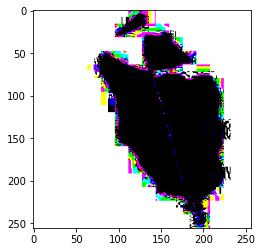

In [ ]:

# Get a sample from dataset and show info
batch = get_next_batch(val_gen)

# Check the performance on the validation set
X_test = batch[0]
y_test = batch[1]
# Predict the test set with the CNN
predictions = xception_ft_aug_model.predict(X_test)
predictions.shape

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))



# Manage imbalanced data

In [ ]:
# class 3
# class 5,6, 12
# test set score
# seems to suffer from data imbalance 


In [ ]:
import numpy as np
import math

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight

# labels_dict recovered from last notebook
labels_dict = {0: 791, 1: 374, 2: 467, 3: 965, 4: 1167, 5: 1399, 6: 782, 7: 612, 8: 573, 9: 212, 10: 1293, 11: 460, 12: 539, 13: 4555}
# 

class_weights=create_class_weight(labels_dict)
print(class_weights)

{0: 1.0, 1: 1.7388465132069, 2: 1.5167730529525347, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.001247570076121, 7: 1.246370028109106, 8: 1.3122165939066925, 9: 2.3065160359494197, 10: 1.0, 11: 1.5318758211382912, 12: 1.3733867397124349, 13: 1.0}


In [ ]:
# create and train first from based on previous augmented model and look a the result
# then if good , train more layer of the fine tuned model
# Re-load the model after transfer learning
xception_ft_aug_weighted_model = tfk.models.load_model('IncpetionFtAugModel1')
xception_ft_aug_weighted_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 Flattening (Flatten)        (None, 131072)            0         
                                                                 
 dropout_4 (Dropout)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 14)                3598  

In [ ]:
#reuse generator from data aug

In [ ]:
# Train the model
xception_ft_aug_weighted_model_history =xception_ft_aug_weighted_model.fit(
    x = aug_train_gen,
    epochs = 200,
    validation_data = val_gen,
    class_weight=class_weights,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)] # Early stopping
).history

Epoch 1/200
56/56 [==============================] - 388s 7s/step - loss: 0.0441 - accuracy: 0.9887 - val_loss: 0.0468 - val_accuracy: 0.9850
Epoch 2/200
56/56 [==============================] - 356s 6s/step - loss: 0.0363 - accuracy: 0.9901 - val_loss: 0.0660 - val_accuracy: 0.9816
Epoch 3/200
56/56 [==============================] - 357s 6s/step - loss: 0.0339 - accuracy: 0.9911 - val_loss: 0.0326 - val_accuracy: 0.9901
Epoch 4/200
56/56 [==============================] - 362s 6s/step - loss: 0.0320 - accuracy: 0.9918 - val_loss: 0.0304 - val_accuracy: 0.9918
Epoch 5/200
56/56 [==============================] - 345s 6s/step - loss: 0.0295 - accuracy: 0.9928 - val_loss: 0.0580 - val_accuracy: 0.9847
Epoch 6/200
56/56 [==============================] - 349s 6s/step - loss: 0.0211 - accuracy: 0.9942 - val_loss: 0.0540 - val_accuracy: 0.9853
Epoch 7/200
56/56 [==============================] - 346s 6s/step - loss: 0.0213 - accuracy: 0.9944 - val_loss: 0.0639 - val_accuracy: 0.9828
Epoch 

In [ ]:
# Save the model
xception_ft_aug_weighted_model.save('IncpetionFtAugWeighModel1') #seved in gdrive(SimplerMOdel)

INFO:tensorflow:Assets written to: IncpetionFtAugWeighModel1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Load the saved model
xception_ft_aug_weighted_model = tfk.models.load_model('IncpetionFtAugWeighModel1')


(Input) image shape: (3539, 256, 256, 3)
Target shape: (3539, 14)

Categorical label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 3
Class name: Peach
Accuracy: 0.9918
Precision: 0.9899
Recall: 0.9943
F1: 0.992


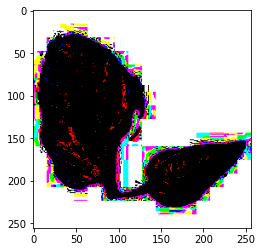

In [ ]:

# Get a sample from dataset and show info
batch = get_next_batch(val_gen)

# Check the performance on the validation set
X_test = batch[0]
y_test = batch[1]
# Predict the test set with the CNN
predictions = xception_ft_aug_weighted_model.predict(X_test)
predictions.shape

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))



# Class imbalance no full retraining but more layer trained

In [ ]:
# class 3
# class 5,6, 12
# test set score
# seems to suffer from data imbalance 


In [ ]:
import numpy as np
import math

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight

# labels_dict recovered from last notebook
labels_dict = {0: 791, 1: 374, 2: 467, 3: 965, 4: 1167, 5: 1399, 6: 782, 7: 612, 8: 573, 9: 212, 10: 1293, 11: 460, 12: 539, 13: 4555}
# 

class_weights=create_class_weight(labels_dict)
print(class_weights)

{0: 1.0, 1: 1.7388465132069, 2: 1.5167730529525347, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.001247570076121, 7: 1.246370028109106, 8: 1.3122165939066925, 9: 2.3065160359494197, 10: 1.0, 11: 1.5318758211382912, 12: 1.3733867397124349, 13: 1.0}


In [ ]:
# create and train first from based on previous augmented model and look a the result
# then if good , train more layer of the fine tuned model
# Re-load the model after transfer learning
xception_ft_aug_weighted_model_more_layer = tfk.models.load_model('IncpetionFtAugWeighModel1')
xception_ft_aug_weighted_model_more_layer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 Flattening (Flatten)        (None, 131072)            0         
                                                                 
 dropout_4 (Dropout)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 14)                3598  

In [ ]:
# Set all xception layers to True
xception_ft_aug_weighted_model_more_layer.get_layer('xception').trainable = True
for i, layer in enumerate(xception_ft_aug_weighted_model_more_layer.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d True
13 block2_pool True
14 batch_normalization True
15 add True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_1 True
23 block3_pool True
24 batch_normalization_1 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_2 True
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 block5_sep

In [ ]:
# Freeze first N layers
N = 80
for i, layer in enumerate(xception_ft_aug_weighted_model_more_layer.get_layer('xception').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(xception_ft_aug_weighted_model_more_layer.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)
xception_ft_aug_weighted_model_more_layer.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

In [ ]:
#reuse generator from data aug

In [ ]:
# Train the model
xception_ft_aug_weighted_model_more_layer_history =xception_ft_aug_weighted_model_more_layer.fit(
    x = aug_train_gen,
    epochs = 50,
    validation_data = val_gen,
    class_weight=class_weights,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)] # Early stopping
).history

Epoch 1/50
56/56 [==============================] - 389s 7s/step - loss: 0.0049 - accuracy: 0.9986 - val_loss: 0.0401 - val_accuracy: 0.9884
Epoch 2/50
56/56 [==============================] - 357s 6s/step - loss: 0.0097 - accuracy: 0.9977 - val_loss: 0.0540 - val_accuracy: 0.9870
Epoch 3/50
Epoch 3/50
56/56 [==============================] - 341s 6s/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.0553 - val_accuracy: 0.9901
Epoch 4/50
Epoch 4/50
56/56 [==============================] - 345s 6s/step - loss: 0.0108 - accuracy: 0.9977 - val_loss: 0.0866 - val_accuracy: 0.9828
Epoch 5/50
Epoch 5/50
56/56 [==============================] - 340s 6s/step - loss: 0.0268 - accuracy: 0.9930 - val_loss: 0.0589 - val_accuracy: 0.9859
Epoch 6/50
Epoch 6/50
56/56 [==============================] - 339s 6s/step - loss: 0.0229 - accuracy: 0.9941 - val_loss: 0.0547 - val_accuracy: 0.9873
Epoch 7/50
Epoch 7/50
56/56 [==============================] - 346s 6s/step - loss: 0.0199 - accuracy: 0.9949 

In [ ]:
# Save the model
xception_ft_aug_weighted_model_more_layer.save('IncpetionFtAugWeighModel1_more_layer') #seved in gdrive(SimplerMOdel)

INFO:tensorflow:Assets written to: IncpetionFtAugWeighModel1_more_layer/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Load the saved model
xception_ft_aug_weighted_model_more_layer = tfk.models.load_model('IncpetionFtAugWeighModel1_more_layer')


(Input) image shape: (3539, 256, 256, 3)
Target shape: (3539, 14)

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 0
Class name: Apple
Accuracy: 0.9929
Precision: 0.991
Recall: 0.9915
F1: 0.9912


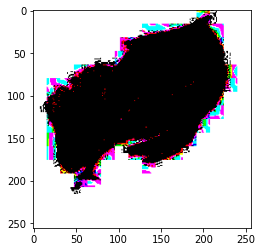

In [ ]:

# Get a sample from dataset and show info
batch = get_next_batch(val_gen)

# Check the performance on the validation set
X_test = batch[0]
y_test = batch[1]
# Predict the test set with the CNN
predictions = xception_ft_aug_weighted_model_more_layer.predict(X_test)
predictions.shape

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))



# Final model

In [ ]:
final_model = tfk.models.load_model('IncpetionFtAugWeighModel1_more_layer')
final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 Flattening (Flatten)        (None, 131072)            0         
                                                                 
 dropout_4 (Dropout)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 14)                3598  

In [ ]:
# Apply same preprocessing used to train the supernet 
from tensorflow.keras.applications.xception import preprocess_input 

# use generator to prepare the data
batch_size = 256
#validation_split = .2

# Create an instance of ImageDataGenerator with augmentation
aug_train_data_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range=30,
    height_shift_range=50,
    width_shift_range=50,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True, 
    fill_mode='reflect',
    #validation_split=validation_split, #set the validation split
    
)

# Obtain a data generatorfor training
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(img_height,img_width),
                                               batch_size=batch_size,                                        
                                               #subset = 'training',
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed)

Found 17728 images belonging to 14 classes.


In [ ]:

import math

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight

# labels_dict recovered from last notebook
labels_dict = {0: 791, 1: 374, 2: 467, 3: 965, 4: 1167, 5: 1399, 6: 782, 7: 612, 8: 573, 9: 212, 10: 1293, 11: 460, 12: 539, 13: 4555}
# 

class_weights=create_class_weight(labels_dict)
print(class_weights)

{0: 1.0, 1: 1.7388465132069, 2: 1.5167730529525347, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.001247570076121, 7: 1.246370028109106, 8: 1.3122165939066925, 9: 2.3065160359494197, 10: 1.0, 11: 1.5318758211382912, 12: 1.3733867397124349, 13: 1.0}


In [ ]:
# Train the model
final_model_history =final_model.fit(
    x = aug_train_gen,
    epochs = 20,
    #validation_data = val_gen,
    class_weight=class_weights
    #callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)] # Early stopping
).history

Epoch 1/20
70/70 [==============================] - 437s 6s/step - loss: 0.0329 - accuracy: 0.9914
Epoch 2/20
70/70 [==============================] - 423s 6s/step - loss: 0.0246 - accuracy: 0.9937
Epoch 3/20
70/70 [==============================] - 419s 6s/step - loss: 0.0223 - accuracy: 0.9946
Epoch 4/20
70/70 [==============================] - 420s 6s/step - loss: 0.0153 - accuracy: 0.9959
Epoch 5/20
70/70 [==============================] - 419s 6s/step - loss: 0.0138 - accuracy: 0.9965
Epoch 6/20
70/70 [==============================] - 406s 6s/step - loss: 0.0142 - accuracy: 0.9970
Epoch 7/20
70/70 [==============================] - 402s 6s/step - loss: 0.0115 - accuracy: 0.9968
Epoch 8/20
70/70 [==============================] - 400s 6s/step - loss: 0.0097 - accuracy: 0.9980
Epoch 9/20
70/70 [==============================] - 410s 6s/step - loss: 0.0102 - accuracy: 0.9971
Epoch 10/20
70/70 [==============================] - 409s 6s/step - loss: 0.0089 - accuracy: 0.9974
Epoch 11/

In [ ]:
# Save the model
final_model.save('FinalModel') #seved in gdrive(SimplerMOdel)

INFO:tensorflow:Assets written to: FinalModel/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
